# Initial Setup

In [638]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.feature_selection import mutual_info_regression
from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

In [639]:
# Constants
data_file_path = "/kaggle/input/home-data-for-ml-course/train.csv"
test_size = 0.2
val_size = 0.2
random_state = 0
set_config(transform_output="pandas")

In [640]:
# Load data
df = pd.read_csv(data_file_path)
df = df.drop(columns=["Id"])

In [641]:
# View sample data
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [642]:
# Target and features
target = "SalePrice"
features = df.columns.tolist()
features.remove(target)

y = df["SalePrice"]
X = df[features]

year_mo_features = ["YearBuilt","YearRemodAdd","GarageYrBlt","MoSold","YrSold"]
numerical_features = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","Bedroom","Kitchen","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]
numerical_features.extend(year_mo_features)
numerical_features.extend(["BedroomAbvGr", "KitchenAbvGr"]) # Not found in data description
numerical_features.extend(["OverallCond", "OverallQual"]) # Ratings
categorical_features = list(set(features) - set(numerical_features))

In [643]:
# Split the data before exploration to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
print(X_train.shape)

(934, 79)


In [644]:
# Unique data types of every column
print("Unique data types:")
print([str(x) for x in np.unique(X_train.dtypes.values)])

Unique data types:
['int64', 'float64', 'object']


# Handle Missing Values

In [645]:
# View null counts and data type per column
def get_df_info(df, missing_only=False):
    """
    Function to get information about the dataframe
    :param df: DataFrame
    :return: DataFrame with column names, non-null counts, and data types
    """
    ret = pd.DataFrame({
        "column": df.columns,
        "non_null_count": df.notnull().sum(),
        "pct_missing": df.isnull().sum() / df.shape[0],
        "data_type": df.dtypes
    }).reset_index(drop=True).sort_values(by=["non_null_count"])
    if missing_only:
        return ret[ret["non_null_count"] < df.shape[0]]
    return ret

missing_info = get_df_info(X_train, missing_only=True)
print(missing_info.to_string())

          column  non_null_count  pct_missing data_type
71        PoolQC               4     0.995717    object
73   MiscFeature              39     0.958244    object
5          Alley              56     0.940043    object
72         Fence             168     0.820128    object
56   FireplaceQu             498     0.466809    object
2    LotFrontage             772     0.173448   float64
58   GarageYrBlt             888     0.049251   float64
57    GarageType             888     0.049251    object
59  GarageFinish             888     0.049251    object
62    GarageQual             888     0.049251    object
63    GarageCond             888     0.049251    object
34  BsmtFinType2             911     0.024625    object
32  BsmtFinType1             912     0.023555    object
31  BsmtExposure             912     0.023555    object
30      BsmtCond             912     0.023555    object
29      BsmtQual             912     0.023555    object
25    MasVnrArea             929     0.005353   

In [646]:
# Impute by filling with a constant value
def impute_fill(df: pd.DataFrame, fit: bool = False):
    if fit:
        imputer = SimpleImputer(strategy="constant", fill_value=0)
        imputer.fit(df)
        impute_fill.imputer = imputer
    return impute_fill.imputer.transform(df)

# Drop columsn with more than 20% missing values
def drop_columns_with_missing_values(df: pd.DataFrame, threshold=None, fit=False):
    """
    Function to drop columns with missing values above a certain threshold
    :param df: DataFrame
    :param threshold: float, percentage of missing values to drop the column
    :return: DataFrame with columns dropped
    """
    df_info = get_df_info(df=df)
    if fit:
        if threshold is None:
            dropped_columns = df_info.loc[df_info["pct_missing"] > 0, "column"].tolist()
        else:
            dropped_columns = df_info.loc[df_info["pct_missing"] > threshold, "column"].tolist()
        drop_columns_with_missing_values.dropped_columns = dropped_columns
    return df.drop(columns=drop_columns_with_missing_values.dropped_columns)
missing_columns_drop_threshold = 0.2
X_train = drop_columns_with_missing_values(X_train, threshold=missing_columns_drop_threshold, fit=True)
missing_info = get_df_info(X_train, missing_only=True)
print(missing_info.to_string())

          column  non_null_count  pct_missing data_type
2    LotFrontage             772     0.173448   float64
55    GarageType             888     0.049251    object
56   GarageYrBlt             888     0.049251   float64
57  GarageFinish             888     0.049251    object
60    GarageQual             888     0.049251    object
61    GarageCond             888     0.049251    object
33  BsmtFinType2             911     0.024625    object
29      BsmtCond             912     0.023555    object
28      BsmtQual             912     0.023555    object
31  BsmtFinType1             912     0.023555    object
30  BsmtExposure             912     0.023555    object
23    MasVnrType             929     0.005353    object
24    MasVnrArea             929     0.005353   float64
40    Electrical             933     0.001071    object


In [647]:
# Number of rows with missing values
def get_rows_missing(df):
    """
    Function to get the number of rows with missing values
    :param df: DataFrame
    :return: Series with counts of missing values per row
    """
    return df.isnull().sum(axis=1).sort_values(ascending=False)
idx = get_rows_missing(X_train)
X_train.loc[idx[idx > 0].index]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1011,90,RL,75.0,9825,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,5,2010,WD,Normal
1179,20,RL,77.0,8335,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,36,190,0,0,0,0,4,2006,WD,Normal
705,190,RM,70.0,5600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3500,7,2010,WD,Normal
1218,50,RM,52.0,6240,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,7,2006,WD,Normal
533,20,RL,50.0,5000,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,0,1,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,60,RL,NaN,9240,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,45,0,0,189,0,0,9,2008,WD,Normal
1443,30,RL,NaN,8854,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,98,0,0,40,0,0,5,2009,WD,Normal
1086,160,RM,NaN,1974,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,96,0,0,0,0,0,5,2010,WD,Normal
180,160,FV,NaN,2117,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2007,WD,Normal


In [648]:
# Mean-impute columns that have less than 5% missing values
# Mode-impute if categorical
missing_lt_5 = missing_info[missing_info["pct_missing"] <= .05]
cols_to_mode_impute = missing_lt_5.loc[missing_lt_5["data_type"] == object, "column"].values.tolist()
for col in cols_to_mode_impute:
    mode = X_train[col].mode(dropna=True)
    if not mode.empty:
        X_train[col] = X_train[col].fillna(mode[0])
    else:
        raise Exception("Mode could not be computed for column: " + col)

cols_to_mean_impute = missing_lt_5.loc[missing_lt_5["data_type"] != object, "column"].values.tolist()
cols_to_mean_impute.remove("GarageYrBlt") # KNN imputation for this column makes more sense
for col in cols_to_mean_impute:
    mean = X_train[col].mean()
    if not np.isnan(mean):
        X_train[col] = X_train[col].fillna(mean)
    else:
        raise Exception("Mean could not be computed for column: " + col)

In [649]:
# Use KNN imputation for columns with more than 5% but less than 20% missing values
missing_lt_20 = missing_info[(missing_info["pct_missing"] > .05) & (missing_info["pct_missing"] <= .2)]
ki = KNNImputer(n_neighbors=10)
imputed = ki.fit_transform(X_train.select_dtypes(include=["number"]))
X_train.loc[:, missing_lt_20["column"].values.tolist()] = imputed
X_train["GarageYrBlt"] = imputed["GarageYrBlt"]

In [650]:
assert (get_df_info(X_train)["pct_missing"] == 0).all(), "There are still missing values"

# Feature Selection

## Numerical Features

In [651]:
# Correlation coefficients for linear relationships
X_train_num = X_train.select_dtypes(include=["number"])
def get_corr(X, y, method: str = "pearson", n: int = 5):
    corr = pd.concat((X_train_num, y_train), axis=1).corr(method=method)
    corr_target = corr.drop([target], axis=0)[target]
    corr_target.sort_values(ascending=False).head(10)
    return corr_target.sort_values(ascending=False).head(10)
pearson = get_corr(X_train_num, y_train, method="pearson", n=10)
print(f"Pearson:\n{pearson}\n")

Pearson:
OverallQual     0.789124
GrLivArea       0.717229
GarageCars      0.665144
GarageArea      0.652219
TotalBsmtSF     0.639281
1stFlrSF        0.621269
FullBath        0.580102
TotRmsAbvGrd    0.526128
YearBuilt       0.524966
YearRemodAdd    0.506072
Name: SalePrice, dtype: float64



In [652]:
spearman = get_corr(X_train_num, y_train, method="spearman", n=10)
print(f"Spearman:\n{spearman}\n")

Spearman:
OverallQual     0.800658
GrLivArea       0.733269
GarageCars      0.716205
GarageArea      0.671856
YearBuilt       0.653710
FullBath        0.645868
GarageYrBlt     0.604743
TotalBsmtSF     0.604157
1stFlrSF        0.572799
YearRemodAdd    0.566367
Name: SalePrice, dtype: float64



In [653]:
kendall = get_corr(X_train_num, y_train, method="kendall", n=10)
print(f"Kendall:\n{pearson}\n")

Kendall:
OverallQual     0.789124
GrLivArea       0.717229
GarageCars      0.665144
GarageArea      0.652219
TotalBsmtSF     0.639281
1stFlrSF        0.621269
FullBath        0.580102
TotRmsAbvGrd    0.526128
YearBuilt       0.524966
YearRemodAdd    0.506072
Name: SalePrice, dtype: float64



In [654]:
# Compute mutual information between two features and the target
mi = mutual_info_regression(X_train_num, y_train)
mi = pd.DataFrame(data=mi, index=X_train_num.columns, columns=["mutual_info"])\
    .sort_values(by="mutual_info", ascending=False)
mi.head(10)

,mutual_info
OverallQual,0.562487
GrLivArea,0.464227
TotalBsmtSF,0.428525
GarageCars,0.378436
GarageArea,0.377437
YearBuilt,0.367616
1stFlrSF,0.338844
MSSubClass,0.294180
GarageYrBlt,0.263359
FullBath,0.257809


In [ ]:
# Variance thresholding - remove features with low variability
# Challenge: the standard deviation of different features have different scales,
# so they need to be scaled first.

# But which scaling strategy to use?
# - Standard-scaling would make all the standard deviations equal to 1, so the
#   variance threshold would be the same for all features. 
# - Min-max scaling could shift the center of the data and is sensitive to outliers
# - Max-abs scaling has the same problem as min-max scaling
# - Compared to standard-scaling, robust scaling substitutes the median for the
#   mean  and the interquartile range for the standard deviation, so it is less
#   sensitive to outliers.
mu = X_train_num.mean(axis=0)
sigma = X_train_num.std(axis=0)
med = X_train_num.median()
iqr = X_train_num.quantile(0.75) - X_train_num.quantile(0.25)

standard_scaled = (X_train_num - mu) / sigma
minmax_scaled = (X_train_num - X_train_num.min()) / (X_train_num.max() - X_train_num.min())
maxabs_scaled = X_train_num / X_train_num.abs().max()
robust_scaled = (X_train_num - med) / iqr

print(standard_scaled.std().sort_values(ascending=False).tail(10), end="\n\n")
print(minmax_scaled.std().sort_values(ascending=False).tail(10), end="\n\n")
print(maxabs_scaled.std().sort_values(ascending=False).tail(10), end="\n\n")
print(robust_scaled.std().sort_values(ascending=False).tail(10), end="\n\n")


# plt.figure()
# sns.kdeplot(data = scaled["OverallCond"], label="OverallCond")
# sns.kdeplot(data = scaled["YearBuilt"], label="YearBuilt")
# plt.title("KDE of Scaled Features")
# plt.ylabel("Density")
# plt.legend()
# std_scaled_num = (X_train_num - mu)/sigma
# std_scaled_num.var()

GarageYrBlt      1.0
GrLivArea        1.0
GarageArea       1.0
WoodDeckSF       1.0
LotFrontage      1.0
EnclosedPorch    1.0
OverallQual      1.0
LotArea          1.0
3SsnPorch        1.0
BsmtHalfBath     1.0
dtype: float64

ScreenPorch      0.115509
EnclosedPorch    0.113153
KitchenAbvGr     0.109833
BedroomAbvGr     0.100141
LowQualFinSF     0.090184
LotFrontage      0.075829
3SsnPorch        0.056642
PoolArea         0.055263
LotArea          0.054499
MiscVal          0.039106
dtype: float64

KitchenAbvGr    0.073222
LotFrontage     0.070741
3SsnPorch       0.056642
PoolArea        0.055263
LotArea         0.054170
MiscVal         0.039106
YearBuilt       0.015288
GarageYrBlt     0.012574
YearRemodAdd    0.010350
YrSold          0.000662
dtype: float64

HalfBath         0.499495
BsmtFinSF2            NaN
LowQualFinSF          NaN
BsmtHalfBath          NaN
KitchenAbvGr          NaN
EnclosedPorch         NaN
3SsnPorch             NaN
ScreenPorch           NaN
PoolArea              Na

21     NaN
1234   NaN
765    NaN
463    NaN
111    NaN
        ..
1206   NaN
248    NaN
1118   NaN
753    NaN
1306   NaN
Name: BsmtFinSF2, Length: 934, dtype: float64

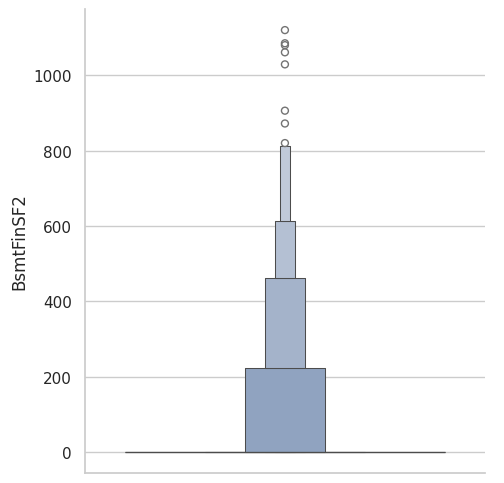

In [672]:
robust_scaled["BsmtFinSF2"]
med["BsmtFinSF2"]
iqr["BsmtFinSF2"]
sns.catplot(y="BsmtFinSF2", data=X_train_num, kind="boxen");

# Misc

In [7]:
# Basic EDA
foo = df.describe()
foo


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [152]:
def encode_ordinal(df: pd.DataFrame, fit: bool = False, categorical_features=None):
    # Safeguard
    categorical_features = list(set(df.columns).intersection(set(categorical_features)))

    # Exclude already-encoded columns
    categorical_features = df[categorical_features].select_dtypes(exclude=["number"]).columns.tolist()
    df = df.copy()
    df[categorical_features] = df[categorical_features].astype(str)
    if fit:
        encoder = OrdinalEncoder()
        ct = ColumnTransformer(transformers=[("encoder", encoder, categorical_features)],
                               remainder="passthrough",
                               verbose_feature_names_out = False)
        ct.fit(df)
        encode_ordinal.encoder = ct
    return encode_ordinal.encoder.transform(df)

def scale(df: pd.DataFrame, columns_to_scale: list[str], fit: bool = False):
    scale_columns = list(set(df.columns).intersection(set(columns_to_scale)))
    if fit:
        scale.scale_columns = scale_columns
        scaler = StandardScaler()
        scaler.fit(df[scale.scale_columns])
        scale.scaler = scaler
    # scaler = MinMaxScaler().fit(X_train_preproc[scale_columns])
    return pd.concat([scale.scaler.transform(df[scale.scale_columns]),
                     df[list(set(df.columns) - set(scale_columns))]], axis=1)

def preproc(df: pd.DataFrame, fit: bool = False):
    # Constants
    imputer = SimpleImputer(strategy="constant", fill_value=0)
    preproc_funcs = [
        # Drop columns with more missing values than missing_columns_drop_threshold
        partial(drop_columns_with_missing_values, threshold=missing_columns_drop_threshold),

        # Impute missing values
        impute_fill,

        # Encode categorical features
        partial(encode_ordinal, categorical_features=categorical_features),

        # Scale numerical features
        partial(scale, columns_to_scale=numerical_features),
    ]

    for f in preproc_funcs:
        df = f(df, fit=True)
    return df

X_train_preproc = preproc(X_train, fit=True)

In [15]:
# Model definition and training
mdl = RandomForestRegressor(random_state=random_state)
mdl.fit(X_train_preproc, y_train)

# Use validation set
X_val_preproc = preproc(X_val)
mae = mean_absolute_error(y_val, mdl.predict(X_val_preproc))
print(f"validation set mae={mae:.2f}")

# Use cross-validation
X_train_val = pd.concat([X_train, X_val])
X_train_val_preproc = preproc(X_train_val)
y_train_val = pd.concat([y_train, y_val])
scores = -1 * cross_val_score(mdl, X_train_val_preproc, y_train_val, cv=5, scoring="neg_mean_absolute_error")
print(f"cross-validation mae={scores.mean():.2f} +/- {scores.std():.2f}")

validation set mae=24874.88
cross-validation mae=17976.74 +/- 857.36


In [ ]:
# Hyperparameter tuning
val_maes = []
cross_val_maes = []
n_trees_search = (2 ** np.arange(15))
for n_trees in n_trees_search:
    print(f"Training for n_trees = {n_trees}")
    mdl = RandomForestRegressor(n_estimators=n_trees, random_state=random_state)
    # Validation set

    mdl.fit(X_train_preproc, y_train)
    val_mae = mean_absolute_error(y_val, mdl.predict(X_val_preproc))
    val_maes.append(val_mae)

    # Cross-validation
    scores = -1 * cross_val_score(mdl, X_train_val_preproc, y_train_val, cv=5, scoring="neg_mean_absolute_error")
    cross_val_maes.append(scores)

val_maes = np.array(val_maes)[:, np.newaxis]
cross_val_maes = np.array(cross_val_maes)

Training for n_trees = 1
Training for n_trees = 2
Training for n_trees = 4
Training for n_trees = 8
Training for n_trees = 16
Training for n_trees = 32
Training for n_trees = 64
Training for n_trees = 128
Training for n_trees = 256
Training for n_trees = 512
Training for n_trees = 1024
Training for n_trees = 2048
Training for n_trees = 4096
Training for n_trees = 8192
Training for n_trees = 16384


In [55]:
# Pick best hyperparameters
df_eval = pd.DataFrame(data =np.concatenate([val_maes,
                                             cross_val_maes.mean(axis=1)[:, np.newaxis]], axis=1),
    columns=["validation", "cross_validation"])
df_eval


,validation,cross_validation
0,35902.256410,28885.334276
1,31793.741453,24202.119669
2,26604.643162,21458.381010
3,26521.338141,20150.173889
4,25354.149306,19716.036861
5,25702.602030,18649.590160
6,25509.169137,18206.221305
7,24776.062033,18007.419637
8,24573.354584,17900.882555
9,24321.888680,17845.788771


In [79]:
# Hyperparameter selection
def select_hp(maes, pct_threshold=0.01, n_consecutive=3):
    """
    Select the hyperparameter preceding consecutive decreases in mae that are
    below a threshold percentage"""
    prev = None
    n_count = 0
    ret = 0
    for n, mae in enumerate(maes):
        # Skip first iteration
        if prev is None:
            prev = mae
            continue
        delta = (prev - mae) / prev
        if delta < pct_threshold:
            # Decrease in mae is below threshold, start counting
            n_count += 1
        else:
            n_count = 0
            ret = n
        print(f"n={n}, mae={mae}, delta={delta:.2f}, n_count={n_count}")
        if n_count >= n_consecutive:
            return ret
        prev = mae

idx_val = select_hp(df_eval["validation"].values)
print("")
idx_cross_val = select_hp(df_eval["cross_validation"].values)
n_trees = n_trees_search[idx_cross_val]
print(f"idx = {idx_cross_val}, n_trees = {n_trees}, mae = {df_eval['cross_validation'].values[idx_cross_val]:.2f}")

n=1, mae=31793.741452991453, delta=0.11, n_count=0
n=2, mae=26604.643162393164, delta=0.16, n_count=0
n=3, mae=26521.33814102564, delta=0.00, n_count=1
n=4, mae=25354.149305555555, delta=0.04, n_count=0
n=5, mae=25702.60202991453, delta=-0.01, n_count=1
n=6, mae=25509.169137286324, delta=0.01, n_count=2
n=7, mae=24776.06203258547, delta=0.03, n_count=0
n=8, mae=24573.35458400107, delta=0.01, n_count=1
n=9, mae=24321.888680221688, delta=0.01, n_count=0
n=10, mae=24341.31174045139, delta=-0.00, n_count=1
n=11, mae=24386.57435438368, delta=-0.00, n_count=2
n=12, mae=24242.36905194144, delta=0.01, n_count=3

n=1, mae=24202.11966912439, delta=0.16, n_count=0
n=2, mae=21458.381010417812, delta=0.11, n_count=0
n=3, mae=20150.173888980597, delta=0.06, n_count=0
n=4, mae=19716.036860579214, delta=0.02, n_count=0
n=5, mae=18649.59016027934, delta=0.05, n_count=0
n=6, mae=18206.22130481732, delta=0.02, n_count=0
n=7, mae=18007.419636883966, delta=0.01, n_count=0
n=8, mae=17900.882554533608, delta

In [80]:
# Retraining with best hyperparameter, and using the validation set as well
X_train_val_preproc = preproc(pd.concat([X_train, X_val]), fit=True)
y_train_val = pd.concat((y_train, y_val))
mdl = RandomForestRegressor(n_estimators=n_trees, random_state=random_state)
mdl.fit(X_train_val_preproc, y_train_val)

RandomForestRegressor(n_estimators=128, random_state=0)

In [82]:
# Estimate accuracy on data set not used for training
mae = mean_absolute_error(y_test, mdl.predict(preproc(X_test, fit=False)))
print(mae)

24414.317128638697


In [83]:
# Retrain on all data to prepare for submission
X_preproc = preproc(X, fit=True)
mdl.fit(X_preproc, y)

RandomForestRegressor(n_estimators=128, random_state=0)

In [86]:
# Load test data and fit
test_data = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
X_test_preproc = preproc(test_data)
test_preds = mdl.predict(preproc(X_test))

In [71]:
# submission = pd.DataFrame({"Id": test_data.Id, "SalePrice": test_preds})
# submission.to_csv("submission.csv", index=False)